In [1]:
import pandas as pd
import os
import shutil
import glob
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4711710084712862418
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12581916841998728057
physical_device_desc: "device: XLA_CPU device"
]


In [16]:
PATH = "./data/"

In [17]:
classes = os.listdir(train)
len(classes)

225

In [18]:
classes

['AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN',
 'ASIAN CRESTED IBIS',
 'BALD EAGLE',
 'BALI STARLING',
 'BANANAQUIT',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BAY-BREASTED WARBLER',
 'BEARDED BARBET',
 'BELTED KINGFISHER',
 'BIRD OF PARADISE',
 'BLACK FRANCOLIN',
 'BLACK SKIMMER',
 'BLACK SWAN',
 'BLACK THROATED WARBLER',
 'BLACK VULTURE',
 'BLACK-CAPPED CHICKADEE',
 'BLACK-NECKED GREBE',
 'BLACK-THROATED SPARROW',
 'BLUE GROUSE',
 'BLUE HERON',
 'BOBOLINK',
 'BROWN NOODY',
 'BROWN THRASHER',
 'CACTUS WREN',
 'CALIFORNIA CONDOR',
 'CALIFORNIA GULL',
 'CALIFORNIA QUAIL',
 'CANARY',
 'CAPE MAY WARBLER',
 'CAPUCHINBIRD',
 'CARMINE BEE-EATER',
 'CASPIAN TERN',
 'CASSOWARY',
 'CHARA DE COLLAR',
 'CHIPPING SPARROW',
 'CINNAMON TEAL',
 'COC

In [19]:
images = []
label = []
for bird in classes:
    x = os.listdir(PATH+bird)
    for i in x:
#         print(Path+dish+"/"+i)
#         img = cv2.imread(Path+dish+"/"+i, cv2.IMREAD_UNCHANGED)
#         resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
#         cv2.imwrite(Path+dish+"/"+i, resized)
        images.append(bird+'_'+i)
        label.append(bird)

In [20]:
print(len(images),  len(label))

33566 33566


In [21]:
df_train = pd.DataFrame(list(zip(images, label)), columns=['Image', 'Bird'])
df_train.Bird.unique()

array(['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET',
       'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT',
       'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT',
       'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD',
       'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE',
       'BALI STARLING', 'BANANAQUIT', 'BAR-TAILED GODWIT', 'BARN OWL',
       'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER',
       'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE',
       'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN',
       'BLACK THROATED WARBLER', 'BLACK VULTURE',
       'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE',
       'BLACK-THROATED SPARROW', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK',
       'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN',
       'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL',
       'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER',
       'CASPIAN TERN', 'CASSOWARY', '

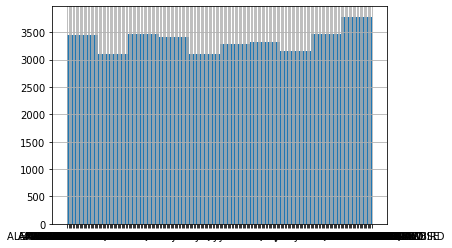

In [22]:
df_train.Bird.hist()

In [23]:
# Augment data
batch_size = 8
train_input_shape = (224, 224, 3)
n_classes = len(classes)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
#                                    shear_range=0.7,
                                   zoom_range=0.5,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=PATH,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=PATH,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=classes
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 26939 images belonging to 225 classes.
Found 6627 images belonging to 225 classes.
Total number of batches = 3367 and 828


In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [26]:
n_epoch = 2

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [27]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=4
                             )

Epoch 1/2
  43/3367 [..............................] - ETA: 6:15:26 - loss: 5.4385 - acc: 0.0087

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/abhi/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [ ]:
# Freeze core ResNet layers and train again 
for layer in model.layers[-6:]:
   layer.trainable = False

for layer in model.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 2
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=4                             
                              )

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Plot the training graph
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [ ]:
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on CV data =", score[1])

In [ ]:
def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=df.Cuisine.unique().tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)